# Assignment 3: Neural networks in natural language processing

### Due Date: Nov 21

### Grade (100 pts, 10%)

*Note: This assignment covers material from the recordings, notes, demos, and suggested readings from Lectures 8,9,11*

---

## Questions

### 1. Dropout (35 pts)

Dropout is a regularization technique that randomly sets units in each activation layer, $a \in \mathbb{R}^{D}$, to zero and then multiplies the resultant vector elementwise by a constant $\gamma$ according to:

$$a' \leftarrow  \gamma m \odot a$$

where $\odot$ represents the element-wise product operator and $m \in \{0, 1\}^D$ is a mask with entries drawn from a Bernoulli distribution: 

$$m_i \sim \begin{cases} 0 &with \quad P=p_{do} \\ 1 &with \quad P=1 - p_{do} \end{cases}$$

Because dropout get's performed at training time and not during inference, blindly applying dropout will lead to a data distribution shift at inference. This is evident in how the hidden layer get's computed:


$$ 
\begin{aligned}
z_{i}^{(l+1)} &= W_{i}^{(l+1)} \cdot a^{'(l)} \quad (training) \\
z_{i}^{(l+1)} &= W_{i}^{(l+1)} \cdot a^{(l)} \quad (inference)
\end{aligned}
$$

where $W_{i}^{(l+1)} \in \mathbb{R}^{D}$. Because $z_{i}^{(l+1)}$ is computed as a weighted sum over the activations from the previous layer, given an identical input, the node values will shift in the absense of dropout unless we scale the activation values (almost certainly; the pathological exception is the case in which the values in $a^{(l)}$ come from a zero mean, zero skew distribution, which is unlikely). To ensure this doesn't happen, derive a training-time scaling constant, ${\gamma}$, that will make each value $z_{i}^{(l+1)}$ invariant (in expectation) to the dropout operation.

*Hint: You want to find the $\gamma$ that makes the following true (in expectation). Some search terms that might come in handy: expectated value of a Bernoulli RV, the weak law of large numbers*.

$$
\sum_{j=0}^{D-1} W_{i,j}^{(l+1)} a_{j}^{(l)}  = \gamma \sum_{j=0}^{D-1} W_{i,j}^{(l+1)} a_{j}^{'(l)}
$$

In [ ]:
# Your answer goes here ...

### 2. Convolutions (30 pts)

Consider a sequence of $T$ token embeddings, $Z \in \mathbb{R}^{T \times D}$, for which $D=3$:

In [164]:
import numpy as np

Z = np.array([
    [1.3,   0.4, -0.2],
    [-3.1,  1.1,  2.1],
    [0.9,   2.8, -1.5],
    [1.3,   2.4,  0.1],
    [1.0,   1.0,  0.5],
    [3.0,  -1.4, -0.2],
    [-0.7,  1.8,  1.3]
])

and a set of convolutional filters, $W=\{ w^{(1)}, w^{(2)} \}$, and corresponding filter widths $S=\{ s^{(1)}, s^{(2)}  \}$:

In [165]:
w1 = np.array([
    [1, 1, 1],
    [1, 1, 1]
])

w2 = np.array([
    [2, 2, 2],
    [2, 2, 2],
    [2, 2, 2]
])

W = [w1, w2]

S = [2, 3]

In Lecture 08 we discussed a set of operations that maps $Z \in \mathbb{R}^{T \times D}$ onto $Z' \in \mathbb{R}^{N_F D}$ (in this problem $N_F = 2$). This involved three steps:

1. **Convolution**: The convolutional operation produces $N_F$ feature maps, $B^{(n)} \in \mathbb{R}^{(T - s^{(n)} + 1) \times D}$, where $n=\{1, \dots, N_F\}$, according to:

$$
\forall_{t \in \{ 1, \dots, T - s^{(n)} + 1 \} } \; B^{(n)}_{t,j} = \sum_{t'=1}^{S^{(n)}} w^{(n)}_{t',j} \; Z_{t+t'-1, \ j}
$$

2. **Max pooling**: The max pooling operation computes the max over the sequence dimension in each feature map, $ B_{maxpool}^{(n)} \in \mathbb{R}^D$, according to:

$$
B_{maxpool, j}^{(n)} = \underset{1 \leq t' \leq T - s^{(n)} + 1 }{\max} B^{(n)}_{t', j}
$$

3. **Concatenation**: The resultant set of $N_F$ feature vectors are then concatenated into a single vector $Z'$ according to:

$$
Z' = \big[ B_{maxpool}^{(1)}, \dots, B_{maxpool}^{(n)}, \dots,  B_{maxpool}^{(N_F)}  \big] \in \mathbb{R}^{D \cdot N_F}
$$

In the cell below, perform these three operations to produce $Z' \in \mathbb{R}^6$ and print it.

*Hint: The max pooling operation computes the maximum over each column in $B^{(n)}$*

In [166]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    for i in range(img_size):
        added = i + kernel_size
        if added <= img_size:
            num_pixels += 1
    return num_pixels

In [167]:
def convolve(img,kernel,n):
    kernel = kernel[:n,:n]
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    k = kernel.shape[0]
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    for i in range(tgt_size):   
        for j in range(tgt_size):
            mat = img[i:i+k, j:j+k]
            try:
              convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            except:
              pass
            
    return convolved_img

In [168]:
Z1 = convolve(Z,w1,2)
Z2 = convolve(Z1,w2,3)
Z2.max(axis=0)

array([53.4, 27.8,  8. ,  0. ])

### 3. Attention (35 pts)

In this problem, you will take a pretrained language model's query, key, and value weight matrices to compute a simple self-attention layer, and then produce a plot of the resultant attention weights, for a single input sequence. 

The input array $X$ is an $T \times D_x$ matrix where $T$ is the number of tokens in your input sequence, and $D_x$ is the dimension of the token embedding. The query mapping $W_q$ is shape $D_x \times D_q$, where $D_q$ is the query dimension. The key mapping $W_k$ is also shape $D_x \times D_q$, and the value mapping $W_v$ is shape $D_x \times D_v$, where $D_v$ is the value dimension. These mappings act on the input aray $X$ to produce the query, key, and value matrices (with associated biases):

$$ Q = XW_q + b_q, \quad K = XW_k + b_k, \quad \text{and} \quad V = XW_v + b_v.$$

With the above computations, we compute the alignments as $E = QK^T / sqrt(D_q)$, and from these unnormalized scores, we obtain attention weights $A$ passing through a softmax: $A = \textrm{softmax}(E)$. Outputs are obtained by computing $Y= A V.$


(A) For the sequence `The quick brown fox jumps over the lazy dog`, compute the self-attention weights using the operations described above for the DistilBERT model (https://huggingface.co/distilbert-base-uncased?text=Paris+is+the+%5BMASK%5D+of+France). You will have to tokenize the inputs in the same way the model was trained. 


(B) For each token in the sequence from (A), visualize its attention weights.


In [1]:
!pip install -q transformers

     |████████████████████████████████| 5.5 MB 30.5 MB/s 
     |████████████████████████████████| 182 kB 61.3 MB/s 
     |████████████████████████████████| 7.6 MB 60.1 MB/s 


In [2]:
# Starter code for (A)

from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
# loop through generator to grab weights and biases
for name, param in model.named_parameters():
    # print(name)            
    if name == "transformer.layer.5.attention.q_lin.weight":
        W_q = param
    if name == "transformer.layer.5.attention.q_lin.bias":
        b_q = param
    if name == "transformer.layer.5.attention.k_lin.weight":
        W_k = param
    if name == "transformer.layer.5.attention.k_lin.bias":
        b_k = param
    if name == "transformer.layer.5.attention.v_lin.weight":
        W_v = param
    if name == "transformer.layer.5.attention.v_lin.bias":
        b_v = param

In [98]:
# Code for (A) here
import numpy as np
import torch

text = "The quick brown fox jumps over the lazy dog"
encoded_input = tokenizer(text,return_tensors='pt')
output = model(**encoded_input)
X = output[0][0]
Q = X.matmul(W_q)+ b_q
K = X.matmul(W_k)+ b_k
V = X.matmul(W_v)+ b_v

Dx, Dq = W_q.shape

E = Q.matmul(K.T)/np.sqrt(Dq)

A = torch.softmax(E,dim=1)
A

tensor([[0.1977, 0.0851, 0.0875, 0.0749, 0.0690, 0.1154, 0.0896, 0.0795, 0.0796,
         0.0933, 0.0284],
        [0.0675, 0.1901, 0.0907, 0.0726, 0.0674, 0.0975, 0.1067, 0.1286, 0.0672,
         0.0777, 0.0340],
        [0.0859, 0.1128, 0.1092, 0.0730, 0.0769, 0.1001, 0.1040, 0.0929, 0.0827,
         0.0944, 0.0682],
        [0.0646, 0.1114, 0.0829, 0.0928, 0.0719, 0.1184, 0.1153, 0.0990, 0.0618,
         0.0841, 0.0978],
        [0.0877, 0.1185, 0.0916, 0.0772, 0.0964, 0.1041, 0.0950, 0.0980, 0.0645,
         0.0932, 0.0738],
        [0.1069, 0.1023, 0.0857, 0.0696, 0.0745, 0.1519, 0.1142, 0.0704, 0.0684,
         0.0925, 0.0635],
        [0.1432, 0.1051, 0.0686, 0.0600, 0.0596, 0.0943, 0.1606, 0.0981, 0.0678,
         0.0819, 0.0608],
        [0.0713, 0.1566, 0.0887, 0.0663, 0.0581, 0.0900, 0.1419, 0.1514, 0.0616,
         0.0729, 0.0410],
        [0.0811, 0.0963, 0.0917, 0.0667, 0.0852, 0.1111, 0.1348, 0.0865, 0.0955,
         0.0993, 0.0519],
        [0.1141, 0.1037, 0.0823, 0.08

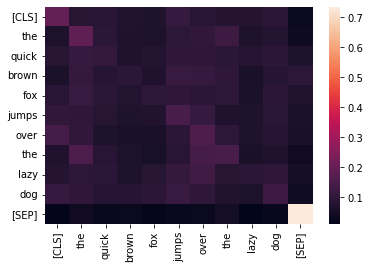

In [101]:
# Code for (B) here
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
A = pd.DataFrame(m.detach().numpy(),
                 columns=tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]),
                 index=tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0]))
sns.heatmap(A)
plt.show()